In [1]:
from ast import increment_lineno
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam



In [2]:
BASE_DIR='UTKFace'

In [3]:
image_paths=[]
gender_labels=[]
age_labels=[]

for filename in tqdm(os.listdir(BASE_DIR)):
  image_path=os.path.join(BASE_DIR,filename)
  temp=filename.split('_')
  age=int(temp[0])
  gender=int(temp[1])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
df=pd.DataFrame()
df['image']=image_paths
df['age']=age_labels
df['gender']=gender_labels
df.head()

image  age  gender
0  UTKFace\100_0_0_20170112213500903.jpg.chip.jpg  100       0
1  UTKFace\100_0_0_20170112215240346.jpg.chip.jpg  100       0
2  UTKFace\100_1_0_20170110183726390.jpg.chip.jpg  100       1
3  UTKFace\100_1_0_20170112213001988.jpg.chip.jpg  100       1
4  UTKFace\100_1_0_20170112213303693.jpg.chip.jpg  100       1

In [5]:
df

image  age  gender
0      UTKFace\100_0_0_20170112213500903.jpg.chip.jpg  100       0
1      UTKFace\100_0_0_20170112215240346.jpg.chip.jpg  100       0
2      UTKFace\100_1_0_20170110183726390.jpg.chip.jpg  100       1
3      UTKFace\100_1_0_20170112213001988.jpg.chip.jpg  100       1
4      UTKFace\100_1_0_20170112213303693.jpg.chip.jpg  100       1
...                                               ...  ...     ...
23703    UTKFace\9_1_3_20161220222856346.jpg.chip.jpg    9       1
23704    UTKFace\9_1_3_20170104222949455.jpg.chip.jpg    9       1
23705    UTKFace\9_1_4_20170103200637399.jpg.chip.jpg    9       1
23706    UTKFace\9_1_4_20170103200814791.jpg.chip.jpg    9       1
23707    UTKFace\9_1_4_20170103213057382.jpg.chip.jpg    9       1

[23708 rows x 3 columns]

In [6]:
gender_dict={0:'Male',1:'Female'}

In [7]:
df.isnull().sum()


image     0
age       0
gender    0
dtype: int64

In [8]:
print(type(df['image'][0]))

<class 'str'>


EXPLORATARY DATA ANALYSIS

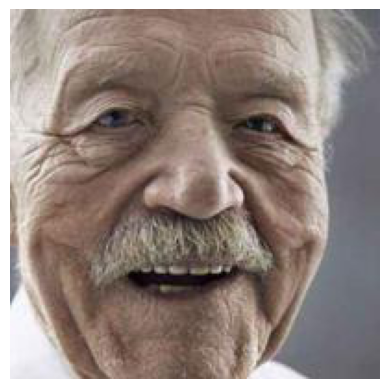

In [18]:
from PIL import Image
img=Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);
plt.show()

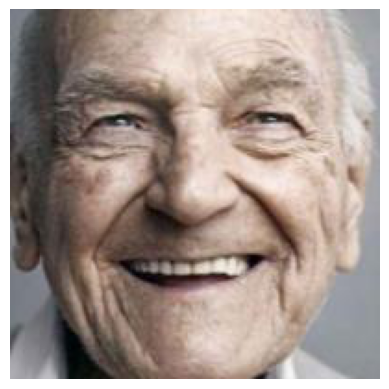

In [20]:
from PIL import Image
img=Image.open(df['image'][1])
plt.axis('off')
plt.imshow(img);
plt.show()

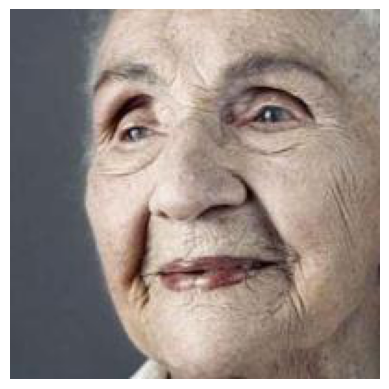

In [22]:
from PIL import Image
img=Image.open(df['image'][3])
plt.axis('off')
plt.imshow(img);
plt.show()

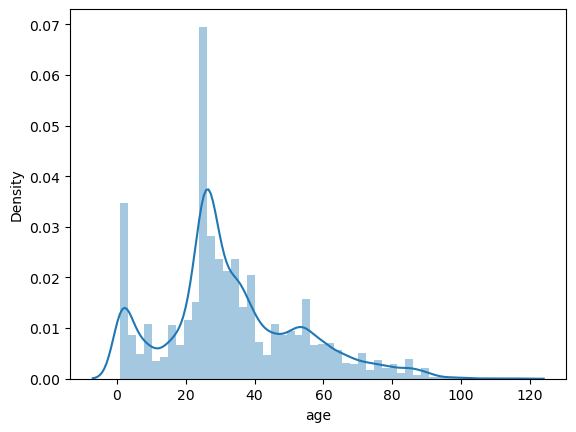

In [24]:
sns.distplot(df['age']);
plt.show()

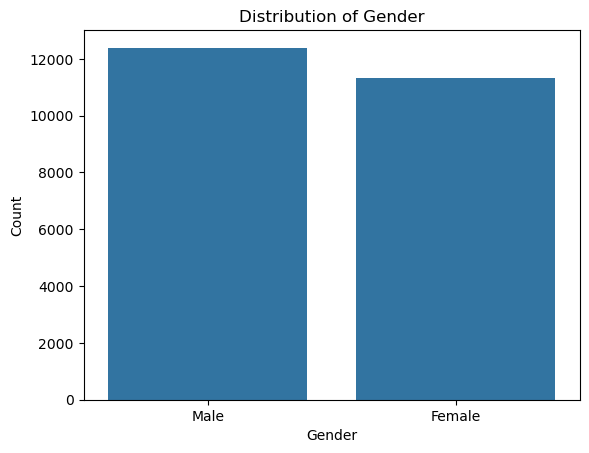

In [26]:
sns.countplot(x='gender', data=df)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Distribution of Gender")
plt.xticks([0, 1], ['Male', 'Female'])  # Assuming 0 is Male and 1 is Female
plt.show()

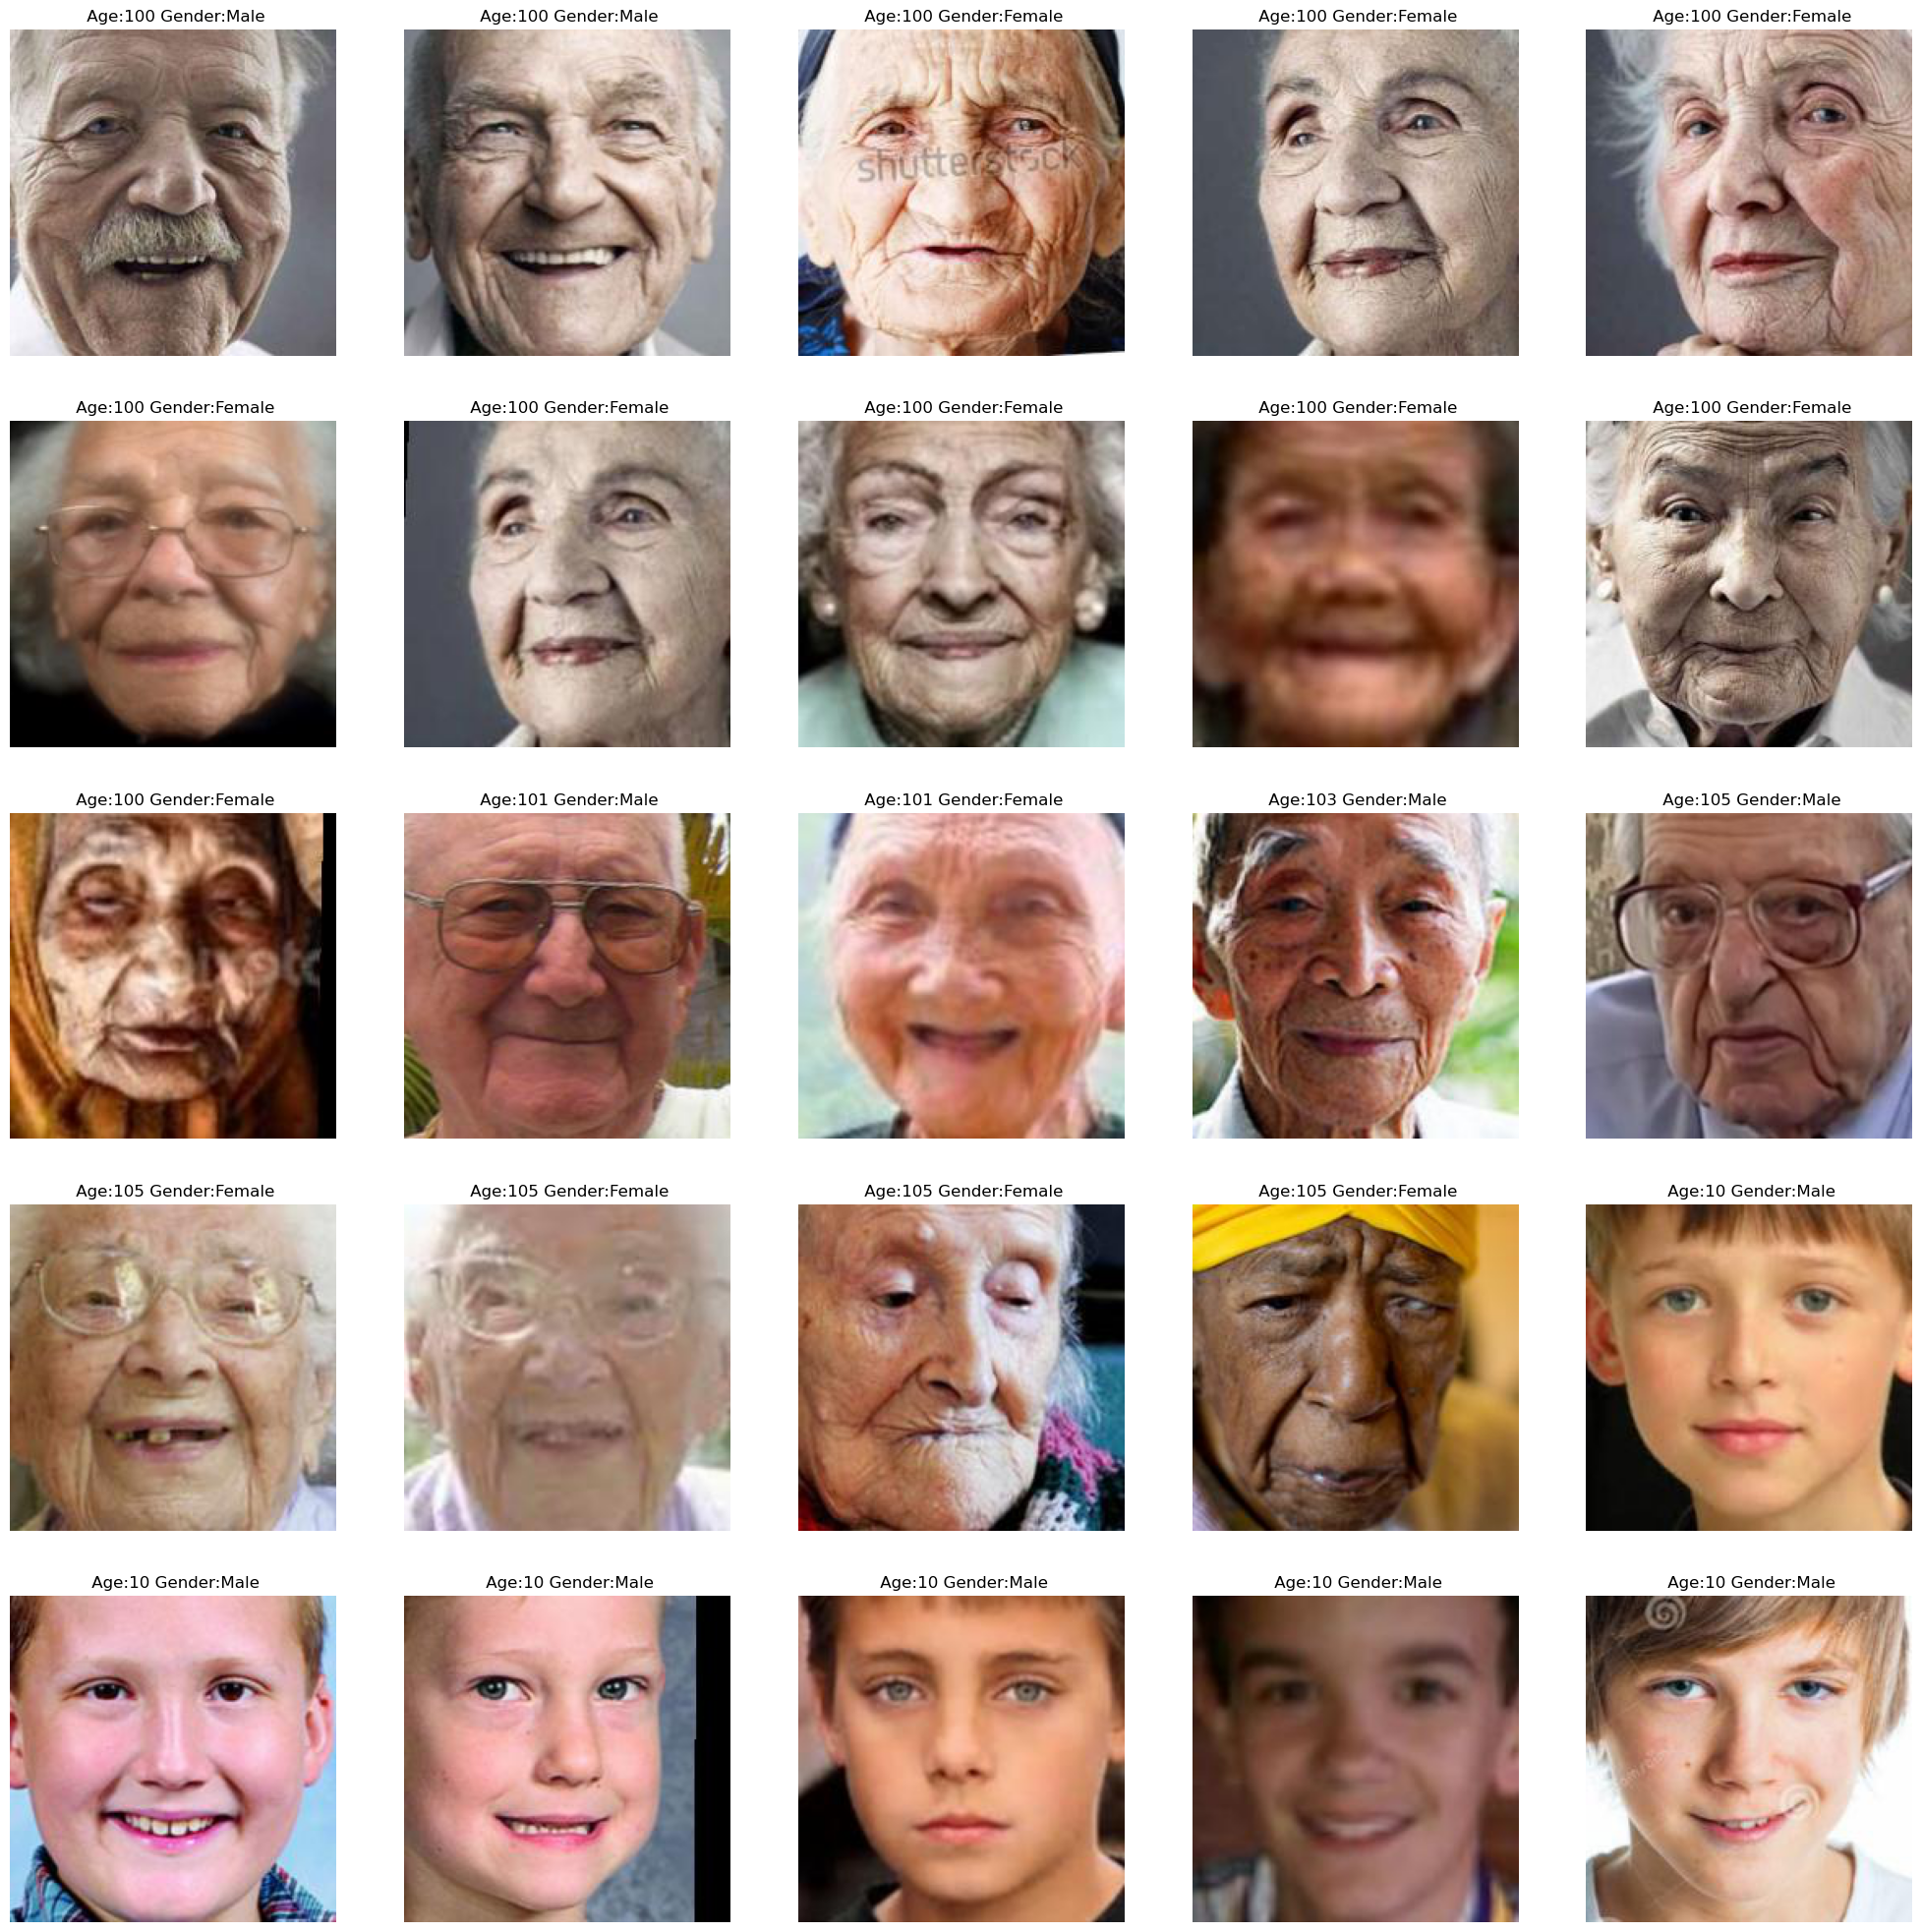

In [28]:
plt.figure(figsize=(25,25))
files=df.iloc[0:25]
for index,file,age,gender in files.itertuples():
  plt.subplot(5,5,index+1)
  img=load_img(file)
  img=np.array(img)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f" Age:{age} Gender:{gender_dict[gender]}")
plt.show()

FEATURE EXTRACTION

In [31]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [33]:
X=extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [35]:
X.shape

(23708, 128, 128, 1)

In [37]:
#NORMALIZE THE IMAGE
X=X/255.0

In [39]:
y_gender=np.array(df['gender'])
y_age=np.array(df['age'])

In [41]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Split the data into training and validation
X_train, X_val, y_gender_train, y_gender_val, y_age_train, y_age_val = train_test_split(
    X, y_gender, y_age, test_size=0.1, random_state=42
)

# Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train, {'gender_out': y_gender_train, 'age_out': y_age_train})
).shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (X_val, {'gender_out': y_gender_val, 'age_out': y_age_val})
).batch(32).prefetch(tf.data.AUTOTUNE)


In [42]:
input_shape=(128,128,1)

Model Creation

In [46]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)
conv_5 = Conv2D(512, kernel_size=(3, 3), activation='relu') (maxp_4)
maxp_5 = MaxPooling2D(pool_size=(2, 2)) (conv_5)


flatten = Flatten() (maxp_5)

# fully connected layers
dense_1 = Dense(512, activation='relu') (flatten)
dense_2 = Dense(512, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='linear', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

optimizer = Adam(learning_rate=0.001)
model.compile(loss=['binary_crossentropy', 'mae'], optimizer=optimizer, metrics=['accuracy', 'mae'])


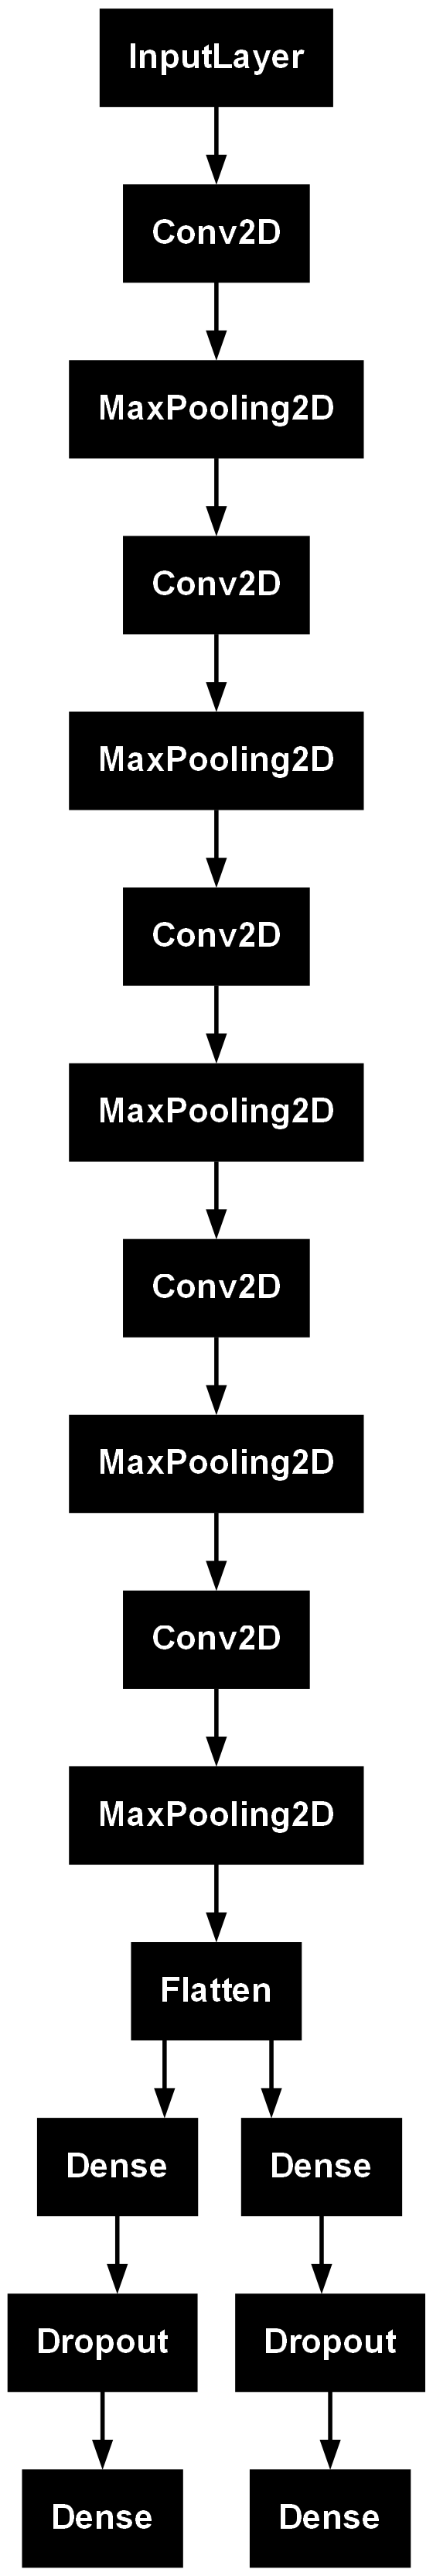

In [48]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)


In [56]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30
)


Epoch 1/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 113s 163ms/step - age_out_loss: 3.1146 - age_out_mae: 3.1146 - gender_out_accuracy: 0.9650 - gender_out_loss: 0.0901 - loss: 3.2047 - val_age_out_loss: 6.2852 - val_age_out_mae: 6.3112 - val_gender_out_accuracy: 0.8663 - val_gender_out_loss: 0.5263 - val_loss: 6.8439
Epoch 2/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 119s 178ms/step - age_out_loss: 3.0808 - age_out_mae: 3.0808 - gender_out_accuracy: 0.9689 - gender_out_loss: 0.0774 - loss: 3.1582 - val_age_out_loss: 6.1159 - val_age_out_mae: 6.1335 - val_gender_out_accuracy: 0.8625 - val_gender_out_loss: 0.5405 - val_loss: 6.6806
Epoch 3/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 115s 172ms/step - age_out_loss: 3.0742 - age_out_mae: 3.0742 - gender_out_accuracy: 0.9647 - gender_out_loss: 0.0855 - loss: 3.1597 - val_age_out_loss: 6.2298 - val_age_out_mae: 6.2214 - val_gender_out_accuracy: 0.8806 - val_gender_out_loss: 0.4433 - val_loss: 6.6701
Epoch 4/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 120s 180ms/step - age_out_loss: 3.09

In [3]:
#model.save("my_model.keras")  


In [50]:
#import tensorflow as tf
#model = tf.keras.models.load_model("my_model.keras")


Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Predicted Gender: Male Predicted Age: 9


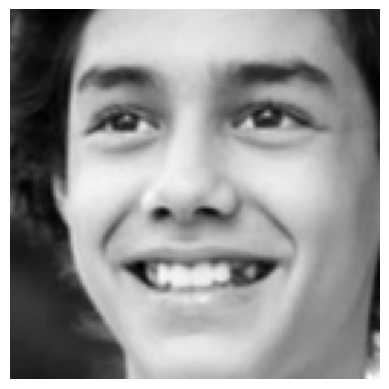

In [62]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Gender: Female Predicted Age: 1


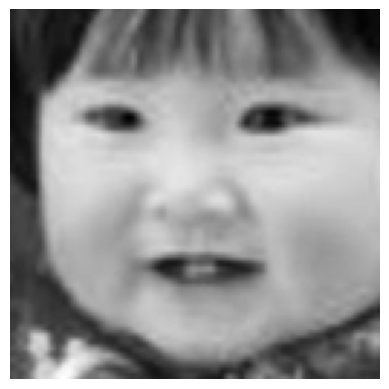

In [64]:
image_index = 2500
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Male Predicted Age: 23


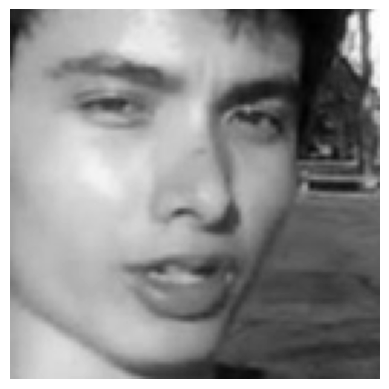

In [66]:
image_index = 5000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Gender: Male Predicted Age: 68


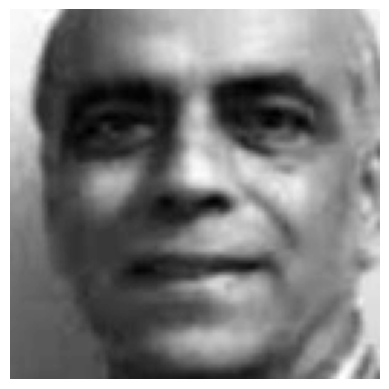

In [68]:
image_index = 21000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Male Predicted Age: 72


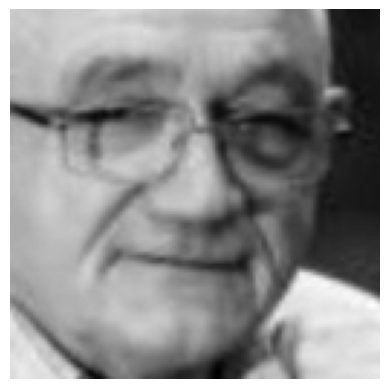

In [70]:
image_index = 22000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Male Predicted Age: 53


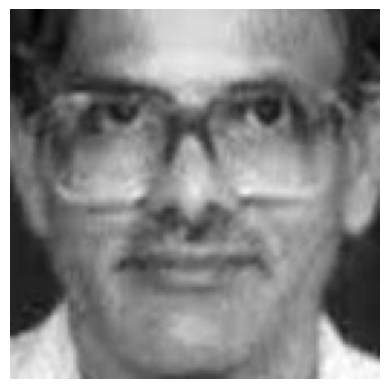

In [72]:
image_index = 20000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Gender: Male Predicted Age: 54


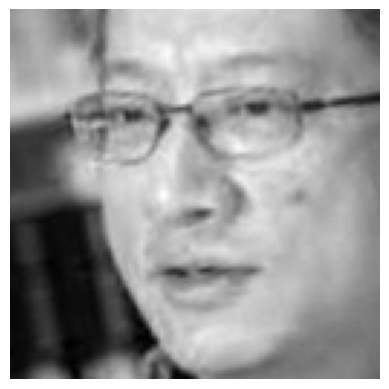

In [74]:
image_index = 19025
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Male Predicted Age: 58


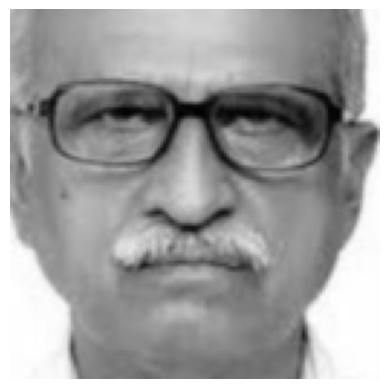

In [76]:
image_index = 20001
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Female Predicted Age: 17


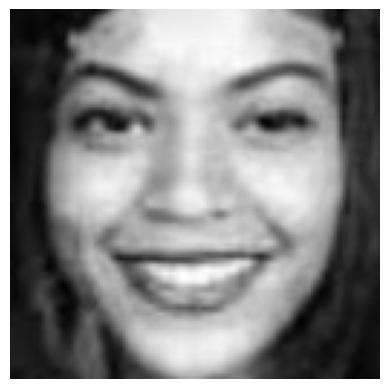

In [78]:
image_index = 1000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Gender: Female Predicted Age: 9


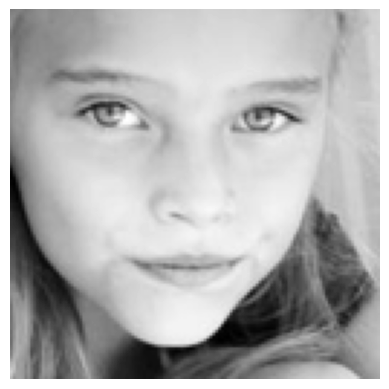

In [80]:
image_index = 230
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Gender: Male Predicted Age: 9


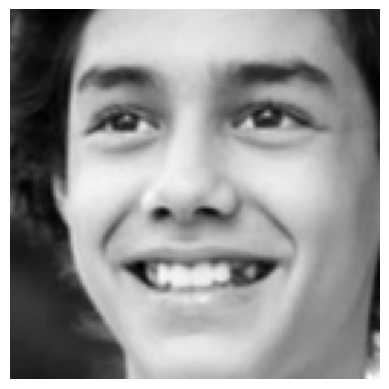

In [82]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Gender: Male Predicted Age: 12


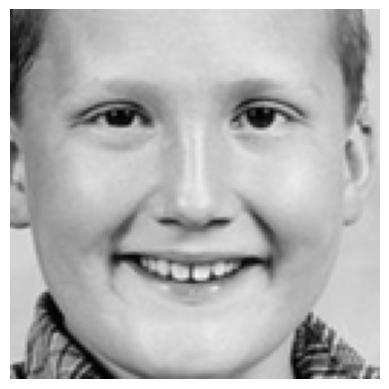

In [84]:
image_index = 20
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Female Predicted Age: 30


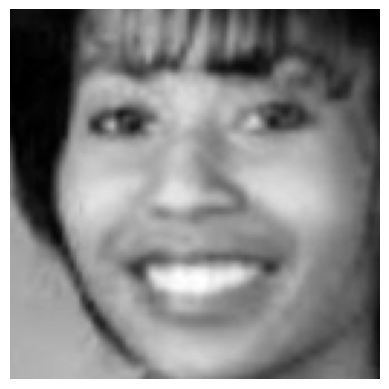

In [86]:
image_index = 15001
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Gender: Male Predicted Age: 48


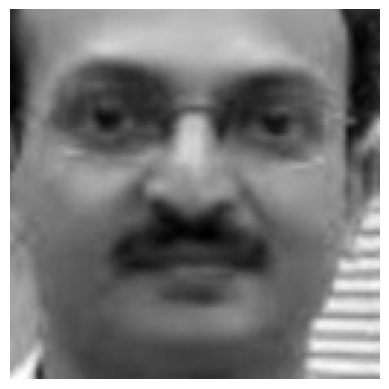

In [88]:
image_index = 19088
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Gender: Female Predicted Age: 31


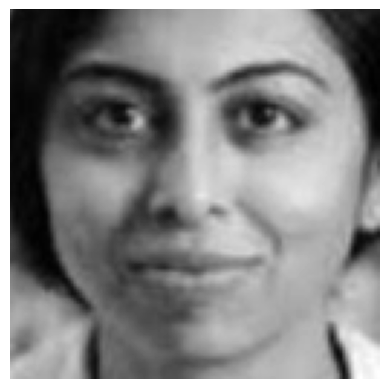

In [90]:
image_index = 10001
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Female Predicted Age: 12


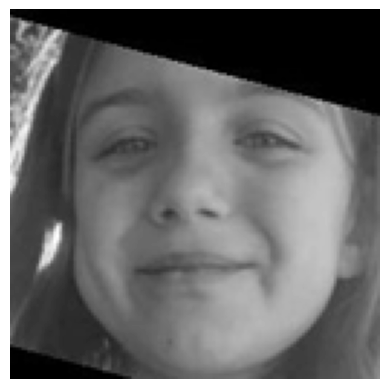

In [92]:
image_index = 152
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Gender: Male Predicted Age: 15


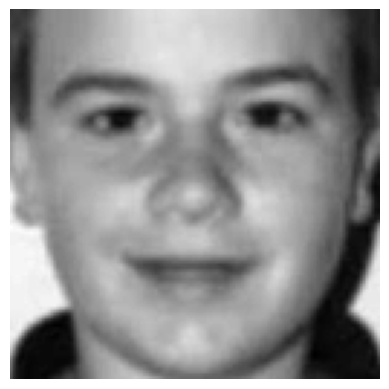

In [94]:
image_index = 255
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Male Predicted Age: 38


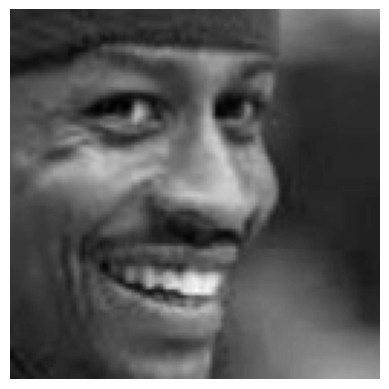

In [96]:
image_index = 12521
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Gender: Female Predicted Age: 31


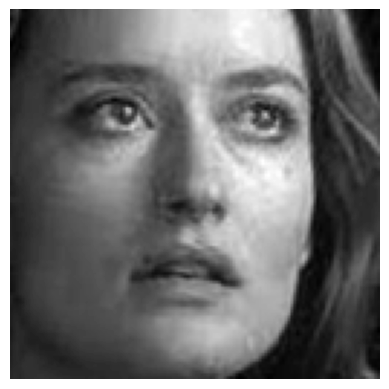

In [98]:
image_index = 12345
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Gender: Female Predicted Age: 26


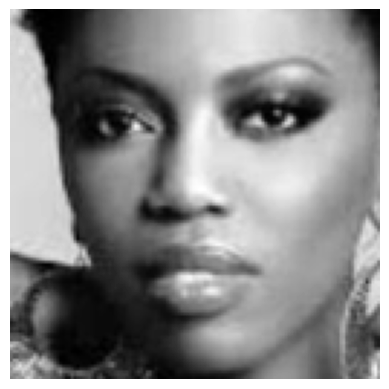

In [100]:
image_index = 5432
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Gender: Male Predicted Age: 20


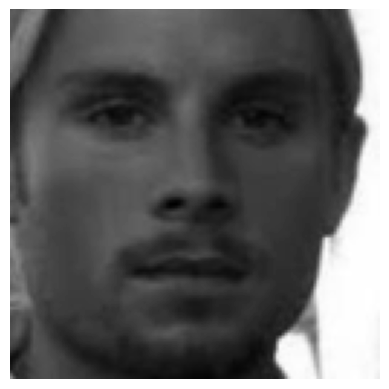

In [102]:
image_index = 3333
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Gender: Female Predicted Age: 30


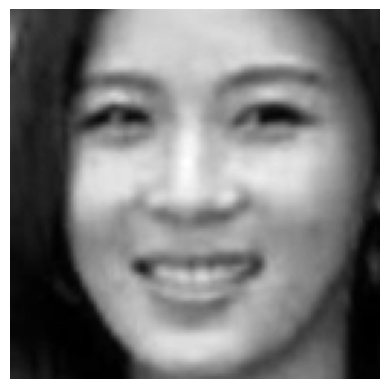

In [104]:
image_index = 11111
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Female Predicted Age: 26


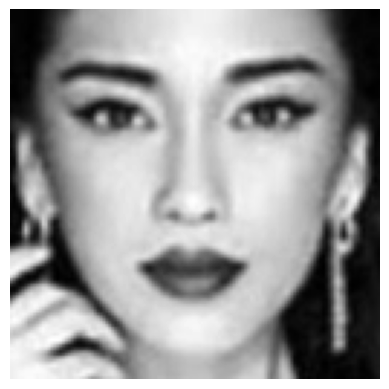

In [106]:
image_index = 5555
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Female Predicted Age: 30


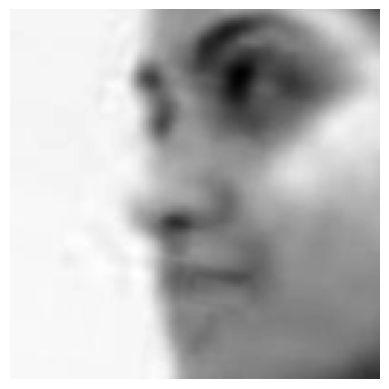

In [108]:
image_index = 5656
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Gender: Female Predicted Age: 27


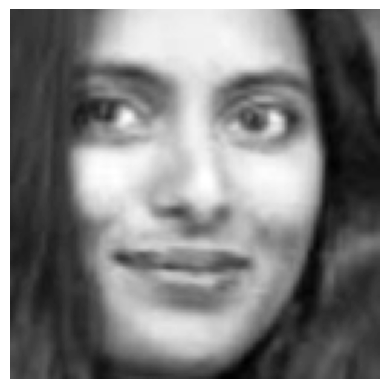

In [110]:
image_index = 9999
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Gender: Male Predicted Age: 24


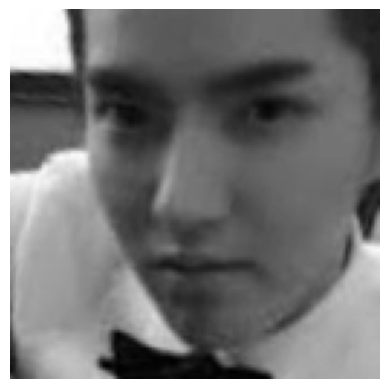

In [112]:
image_index = 8852
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Gender: Male Predicted Age: 49


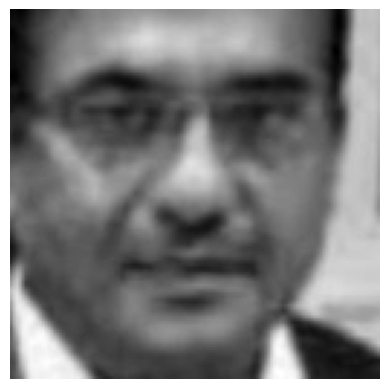

In [114]:
image_index = 6549
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Female Predicted Age: 21


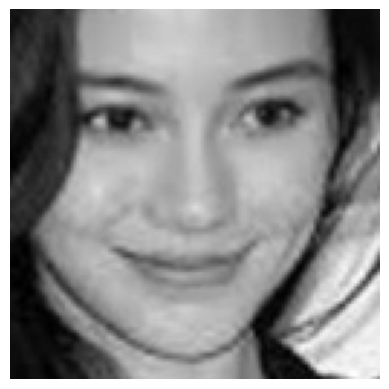

In [116]:
image_index = 7537
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Gender: Male Predicted Age: 26


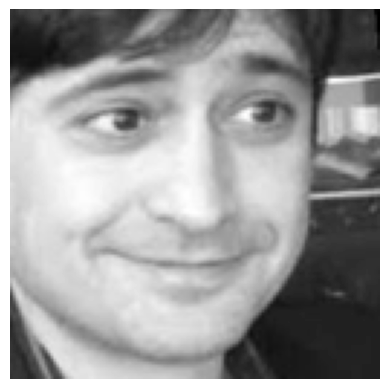

In [118]:
image_index = 9519
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Gender: Female Predicted Age: 28


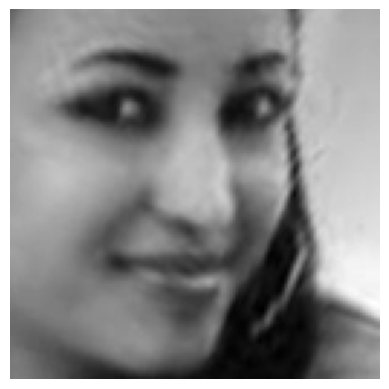

In [120]:
image_index = 7858
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Female Predicted Age: 25


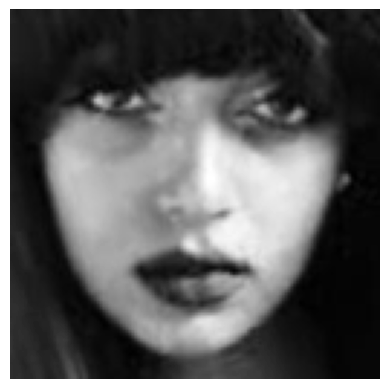

In [122]:
image_index = 7222
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Male Original Age: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Gender: Male Predicted Age: 30


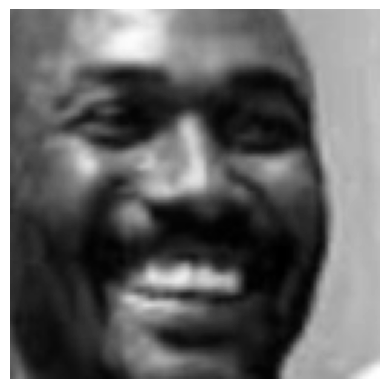

In [124]:
image_index = 9639
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

Original Gender: Female Original Age: 27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Gender: Male Predicted Age: 21


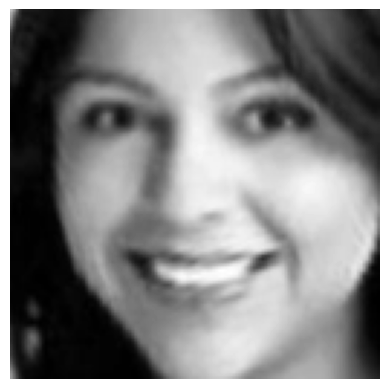

In [126]:
image_index = 8528
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

In [1]:
import os
from flask import Flask, render_template, request, send_from_directory, url_for
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from threading import Thread
import webbrowser

# Setup
app = Flask(__name__)
UPLOAD_FOLDER = 'static/uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
os.makedirs('templates', exist_ok=True)
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

# Load your trained model
model = load_model("my_model.keras")

# Image Preprocessing
def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(128, 128))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Flask route
@app.route("/", methods=["GET", "POST"])
def index():
    gender = None
    age = None
    image_path = None

    if request.method == "POST":
        file = request.files["image"]
        if file.filename == "":
            return "No file selected"

        filepath = os.path.join(app.config['UPLOAD_FOLDER'], file.filename)
        file.save(filepath)

        # Predict
        img = preprocess_image(filepath)
        gender_pred, age_pred = model.predict(img)

        gender = "Female" if gender_pred[0][0] > 0.5 else "Male"
        age = int(age_pred[0][0])

        filename = os.path.basename(filepath)
        image_path = f"uploads/{filename}"

    return render_template("index.html", gender=gender, age=age, image_path=image_path)

# Serve uploaded files
@app.route('/uploads/<filename>')
def uploaded_file(filename):
    return send_from_directory(app.config['UPLOAD_FOLDER'], filename)

# Save HTML template
html = """
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Age and Gender Prediction</title>
  <style>
    body {
      font-family: Arial, sans-serif;
      padding: 40px;
      margin: 0;
      background: linear-gradient(to bottom right, #e0eafc, #cfdef3);
      overflow-x: hidden;
    }
    .bubbles {
      position: fixed;
      top: 0; left: 0;
      width: 100%; height: 100%;
      z-index: -1;
      overflow: hidden;
    }
    .bubble {
      position: absolute;
      bottom: -100px;
      width: 40px; height: 40px;
      background: rgba(255,255,255,0.2);
      border-radius: 50%;
      animation: rise 10s infinite ease-in;
    }
    @keyframes rise {
      0% { transform: translateY(0) scale(1); }
      100% { transform: translateY(-1200px) scale(1.5); }
    }
    h1 {
      font-size: 2.5rem;
      color: #333;
      overflow: hidden;
      white-space: nowrap;
      border-right: 3px solid #007BFF;
      width: 0;
      animation: typing 3s steps(30, end) forwards;
    }
    @keyframes typing {
      from { width: 0 }
      to { width: 100% }
    }
    form {
      margin: 30px auto;
      background: white;
      padding: 30px;
      border-radius: 10px;
      box-shadow: 0 0 15px rgba(0,0,0,0.1);
      width: 350px;
      opacity: 0;
      animation: fadeIn 1.2s ease forwards;
    }
   input[type="file"] {
    display: none;
}

/* Custom file upload styling */
.custom-file-upload {
    display: inline-block;
    background: #f0f0f0;
    color: #333;
    padding: 10px 20px;
    border: 2px dashed #007BFF;
    border-radius: 8px;
    cursor: pointer;
    transition: all 0.3s ease;
    margin-bottom: 15px;
}

.custom-file-upload:hover {
    background-color: #007BFF;
    color: white;
    border-style: solid;
}

/* Predict button styling */
.predict-btn {
    padding: 10px 25px;
    font-size: 16px;
    background: linear-gradient(to right, #007BFF, #00c6ff);
    color: white;
    border: none;
    border-radius: 8px;
    cursor: pointer;
    box-shadow: 0 4px 10px rgba(0, 123, 255, 0.3);
    transition: transform 0.2s ease, box-shadow 0.3s ease;
}

.predict-btn:hover {
    transform: scale(1.05);
    box-shadow: 0 6px 15px rgba(0, 123, 255, 0.4);
}
    .result {
      margin-top: 30px;
      opacity: 0;
      animation: slideFadeIn 1.5s ease forwards;
    }
    @keyframes fadeIn {
      0% { opacity: 0; transform: translateY(10px); }
      100% { opacity: 1; transform: translateY(0); }
    }
    @keyframes slideFadeIn {
      0% { opacity: 0; transform: translateY(40px); }
      100% { opacity: 1; transform: translateY(0); }
    }
    img.preview {
      display: none;
      margin-top: 15px;
      max-width: 200px;
      border-radius: 10px;
      box-shadow: 0 0 10px rgba(0,0,0,0.2);
      transition: opacity 0.6s ease;
    }
    img:hover {
      transform: scale(1.05);
    }
    .spinner {
      display: none;
      margin: 20px auto;
      border: 5px solid #f3f3f3;
      border-top: 5px solid #007BFF;
      border-radius: 50%;
      width: 40px;
      height: 40px;
      animation: spin 1s linear infinite;
    }
    @keyframes spin {
      0% { transform: rotate(0deg); }
      100% { transform: rotate(360deg); }
    }
  </style>

  <script src="https://cdn.jsdelivr.net/npm/canvas-confetti@1.6.0/dist/confetti.browser.min.js"></script>
</head>
<body>
  <div class="bubbles">
    <div class="bubble" style="left: 10%; animation-duration: 10s;"></div>
    <div class="bubble" style="left: 25%; animation-duration: 12s;"></div>
    <div class="bubble" style="left: 50%; animation-duration: 15s;"></div>
    <div class="bubble" style="left: 75%; animation-duration: 11s;"></div>
    <div class="bubble" style="left: 90%; animation-duration: 14s;"></div>
  </div>

  <h1>Age and Gender Prediction</h1>

  <form method="POST" enctype="multipart/form-data" onsubmit="showSpinner()">
        <label for="file-upload" class="custom-file-upload">📁 Choose Image</label>
        <input id="file-upload" type="file" name="image" accept="image/*" onchange="previewImage(event)" required>
        <img id="preview" class="preview" src="#" alt="Image Preview" />
        <button type="submit" class="predict-btn">🔍 Predict</button>
        <div id="spinner" class="spinner"></div>
    </form>

  {% if gender and age %}
  <div id="result-card" class="result">
    <h2>Prediction Result</h2>
    <div style="display: flex; align-items: center; gap: 20px; flex-wrap: wrap;">
      <img src="{{ url_for('static', filename=image_path) }}" width="200px" style="border-radius: 10px;">
      <div style="max-width: 300px;">
        <p><strong>Gender:</strong> {{ gender }}</p>
        <p><strong>Estimated Age:</strong> {{ age }}</p>
        <p style="margin-top: 10px; background: #f1f5fb; padding: 12px; border-left: 4px solid #007BFF; border-radius: 5px;">
          The model predicts this person is likely a <strong>{{ age }}</strong>-year-old <strong>{{ gender }}</strong>.
        </p>
      </div>
    </div>
  </div>
  {% endif %}

  <script>
    function showSpinner() {
      document.getElementById('spinner').style.display = 'block';
    }

    function previewImage(event) {
      const reader = new FileReader();
      reader.onload = function () {
        const output = document.getElementById('preview');
        output.src = reader.result;
        output.style.display = 'block';
        output.style.opacity = 0;
        setTimeout(() => output.style.opacity = 1, 50);
      };
      reader.readAsDataURL(event.target.files[0]);
    }

    function triggerConfetti() {
      const duration = 1 * 1000;
      const animationEnd = Date.now() + duration;
      const defaults = { startVelocity: 30, spread: 360, ticks: 60, zIndex: 1000 };
      function randomInRange(min, max) {
        return Math.random() * (max - min) + min;
      }
      const interval = setInterval(function () {
        const timeLeft = animationEnd - Date.now();
        if (timeLeft <= 0) return clearInterval(interval);
        confetti(Object.assign({}, defaults, {
          particleCount: 5,
          origin: { x: randomInRange(0.1, 0.9), y: Math.random() - 0.2 }
        }));
      }, 250);
    }

    function speakPrediction(gender, age) {
      const message = `The predicted gender is ${gender}, and the estimated age is ${age} years old.`;
      const utterance = new SpeechSynthesisUtterance(message);
      utterance.lang = 'en-US';
      utterance.pitch = 1.1;
      utterance.rate = 1;
      speechSynthesis.speak(utterance);
    }

    window.onload = function () {
      const gender = "{{ gender }}";
      const age = "{{ age }}";
      if (gender && age) {
        triggerConfetti();
        speakPrediction(gender, age);
      }
    };
  </script>
</body>
</html>
"""

with open("templates/index.html", "w",encoding="utf-8") as file:
    file.write(html)

# Run the Flask app
def run():
    app.run(debug=False, use_reloader=False, port=5000)

thread = Thread(target=run)
thread.start()
webbrowser.open("http://127.0.0.1:5000")


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


True